# Module 4: TDD

We want to build a product that relies on a predictive model that allow us to target a set of users that are highly likely to be interested in an item of our choice that we want to promote to send them a push notification. More specifically, we will be developing a machine learning model that, given a user and a product, predicts if the user would purchase it if they were buying with us at that point in time. 

This way, we will be sending push notifications to our users is an effective manner to boost sales and offer discounts to incentivate user engagement with our targeted products without been intrusive and sending too many notifications, since this can generate user disatisfaction and generate churn.

It is worth mentioning that the target impact is to increase our monthly sales by 2% and a boost of 25% over the selected items.

For this product, we have two requirements:
* We are only interested in users that purchase the item along with at least other 4 (minimum 5 items basket)
* The system should allow sales operators to select an item from a dropdown or search bar, get the segment of users to target and trigger a customizable push notification.


## 0. Importing necessary libraries

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, average_precision_score, log_loss, precision_recall_curve, roc_auc_score, roc_curve

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler



## 1. Data processing
In this dataset, every row representes an (order, product) pair where outcome indicates whether the product was bought or not on that specific order and every other feature has been computed only looking at information prior to that order in order to avoid information leakage.

It is worth remembering that the column outcome indicates, for each order, if a certain product has been bought (for the whole catalogue of products). Therefore, there are lots of 0 outcome instances, and the dataset is imbalanced.

In [3]:
file_path = Path("/mnt/c/Users/Adriana/Desktop/ZRIVE/data/groceries/box_builder_dataset/feature_frame.csv")

# Temporarily adjust the max columns displayed
pd.set_option('display.max_columns', None)

data = pd.read_csv(file_path)
data.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,active_snoozed,set_as_regular,normalised_price,discount_pct,vendor,global_popularity,count_adults,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.038462,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
4,33826472919172,ricepastapulses,2808429314180,3537167515780,2020-10-06 10:37:05,2020-10-06 00:00:00,3,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.038462,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


In [40]:
data.shape

(2880549, 27)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880549 entries, 0 to 2880548
Data columns (total 27 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults                      fl

In [42]:
information_cols = ['variant_id', 'order_id', 'user_id', 'created_at', 'order_date']
target_col = 'outcome'
feature_cols = [col for col in data.columns if col not in information_cols + [target_col]]

categorical_cols = ['product_type', 'vendor']
binary_cols = ['ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular']
numerical_cols = [col for col in feature_cols if col not in categorical_cols + binary_cols]

In [43]:
data['variant_id'] = data['variant_id'].astype('str')
data['order_id'] = data['order_id'].astype('str')
data['user_id'] = data['user_id'].astype('str')

data['created_at'] = data['created_at'].astype('datetime64[us]')
data['order_date'] = data['order_date'].astype('datetime64[us]')

data['outcome'] = data['outcome'].astype(int)

for col in binary_cols:
    data[col] = data[col].astype(int)

# Iterate over each column and check if it starts with 'count_'
for col in data.columns:
    if col.startswith('count_'):
        # Convert the column to integer type
        data[col] = data[col].astype(int)

data['people_ex_baby'] = data['people_ex_baby'].astype('int64')

data['days_since_purchase_variant_id'] = data['days_since_purchase_variant_id'].astype('int64')
data['days_since_purchase_product_type'] = data['days_since_purchase_product_type'].astype('int64')

It is worth mentioning that, since we have being working on this dataset over the latest several weeks, this project skips the Exploratory Data Analysis (EDA) phase as it is already available in previous reports. If you want to have a look at the EDA performed, please check these two files:
- https://github.com/adrianadiaz02/zrive-ds/blob/main/src/module_2/Module_2_EDA_Ex1.md (Understanding the problem space)
- https://github.com/adrianadiaz02/zrive-ds/blob/main/src/module_2/Module_2_EDA_Ex2.md (EDA)

## Milestone 1: Exploration Phase
### 1. Building the dataset

#### 1.1 Filtering the data to orders with at least 5 items

Firstly, we filter the data to only those orders with at least 5 items to build a dataset to work with, since they are our target. 

In [44]:
order_size = data.groupby('order_id').outcome.sum()

# Identify orders with size at least 5 and extract the order_id of these big orders
big_orders = order_size[order_size >= 5].index 

# Filter data to only include rows where order_id is in the list of big_orders
filtered_data = data.loc[lambda x: x.order_id.isin(big_orders)]

In [8]:
filtered_data.shape

(2163953, 27)

#### 1.2 Splitting the data

In [9]:
# Get how many orders are performed each day
daily_orders = filtered_data.groupby('order_date').order_id.nunique()
daily_orders.head()

order_date
2020-10-05     3
2020-10-06     7
2020-10-07     6
2020-10-08    12
2020-10-09     4
Name: order_id, dtype: int64

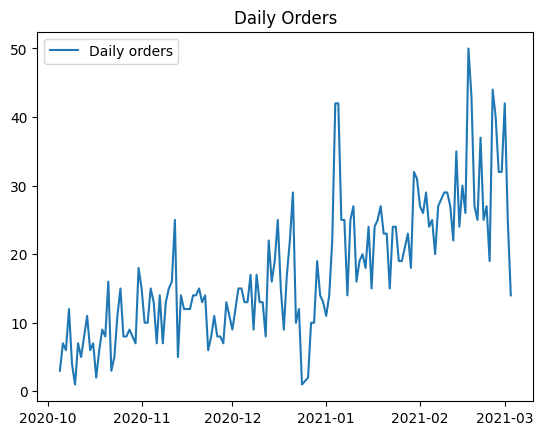

In [10]:
fig, ax = plt.subplots()
ax.plot(daily_orders, label="Daily orders")
ax.set_title("Daily Orders")
ax.legend()
plt.show()

**Important**: It's evident that there is a significant time-based aspect, signaling changes in patterns and business evolution over time. Consequently, it is prudent to implement a temporal split. This approach not only captures the dynamic nature of the data but also ensures that the same order does not appear in both the training and testing sets, thereby preventing information leakage.

In [11]:
cum_sum_daily_orders = daily_orders.cumsum() / daily_orders.sum()

train_val_cut = cum_sum_daily_orders[cum_sum_daily_orders <= 0.7].idxmax()
val_test_cut = cum_sum_daily_orders[cum_sum_daily_orders <= 0.9].idxmax()

print("Train set from: ", cum_sum_daily_orders.index.min())
print("Train set until: ", train_val_cut)
print("Validation set from: ", val_test_cut)
print("Test set until: ", cum_sum_daily_orders.index.max())

Train set from:  2020-10-05 00:00:00
Train set until:  2021-02-04 00:00:00
Validation set from:  2021-02-22 00:00:00
Test set until:  2021-03-03 00:00:00


It is important to consider what is the minimum business cicle, that is, the minimum temporal window that allows us to capture the complete dynamics of the data we want to model. Even though the validation and test splits don't comprise many days, we consider these should be sufficient for our case.

In [12]:
train_data = filtered_data[filtered_data.order_date <= train_val_cut]
val_data = filtered_data[(filtered_data.order_date > train_val_cut) & (filtered_data.order_date <= val_test_cut) ]
test_data = filtered_data[filtered_data.order_date > val_test_cut]

Divide into features and target:

In [45]:
def feature_target_split(df, target):
    X = df.drop(columns=[target]) 
    Y = df[target]   # Target variable we want to predict
    return X, Y

X_train, Y_train = feature_target_split(train_data, target_col)
X_val, Y_val = feature_target_split(val_data, target_col)
X_test, Y_test = feature_target_split(test_data, target_col)

### 2. Defining a Baseline model

In order to be able to decide if a ML model generates any value, we need to compare it against baselines that do not require training. In this case, we will use the global popularity feature as baseline, that is, the product will be predicted to be bought the more popular it is.

In [14]:
def plot_curves(y_true, y_pred, curve_type="both", dataset_type="train"):
    """ Plot the Precision-Recall and ROC curves, together with their AUC.
    Curve_type can be "precision-recall", "roc", or "both", and determine what  are the plotted curves.
    Dataset_type is used to plot in the title wether the the predictions are done in training, test or validation."""
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f"{dataset_type.capitalize()} Dataset - Performance Curves")

    if curve_type in ["precision-recall", "both"]:
        # Compute the precision-recall curve and its AUC
        precision, recall, _ = precision_recall_curve(y_true, y_pred)
        pr_auc = auc(recall, precision)
        
        axes[0].step(recall, precision)
        axes[0].set_xlabel('Recall')
        axes[0].set_ylabel('Precision')
        axes[0].set_title(f'Precision-Recall Curve (AUC={pr_auc:.2f})')

    if curve_type in ["roc", "both"]:
        # Compute the ROC curve and its AUC
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)

        axes[1].plot(fpr, tpr)
        axes[1].set_xlabel('False Positive Rate')
        axes[1].set_ylabel('True Positive Rate')
        axes[1].set_title(f'ROC Curve (AUC={roc_auc:.2f})')

    plt.tight_layout()
    plt.show()


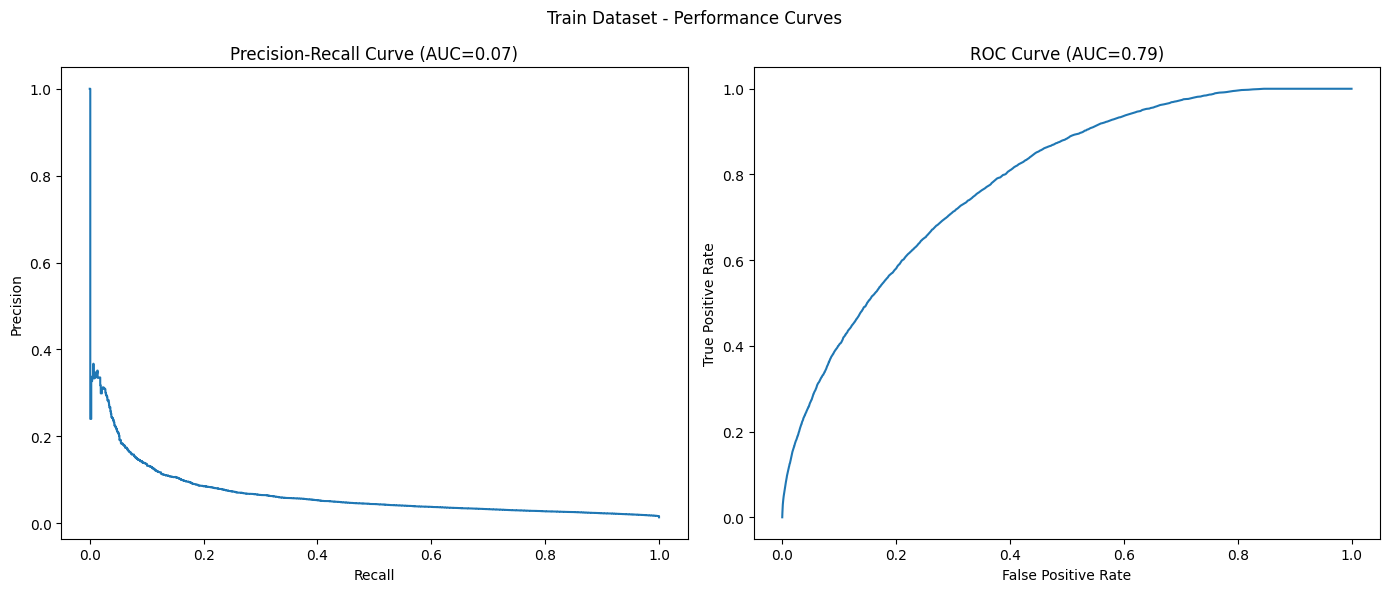

In [15]:
y_pred = val_data['global_popularity']
y_true = val_data['outcome']


plot_curves(y_true, y_pred, curve_type="both", dataset_type="train")


We can observe the AUC of the Precision-Recall plot is of 0.07 and for the ROC curve it is 0.79.

### 3. Linear Models
In the previous module, we explored different linear models (logistic regression) with different parametrisations, regularisations (Ridge and Lasso), and set of features. If interested, please consult the corresponding notebook:
- https://github.com/adrianadiaz02/zrive-ds/blob/main/src/module_3/Module3_Milestone1.md 

Nevertheless, it is worth mentioning that the final model chosen was a Logistic Regression with L2 penalty, an hyperparameter value for C of 1e-4, and only the subset of features from the numerical columns ('ordered_before', 'global_popularity', 'abandoned_before', 'normalised_price):

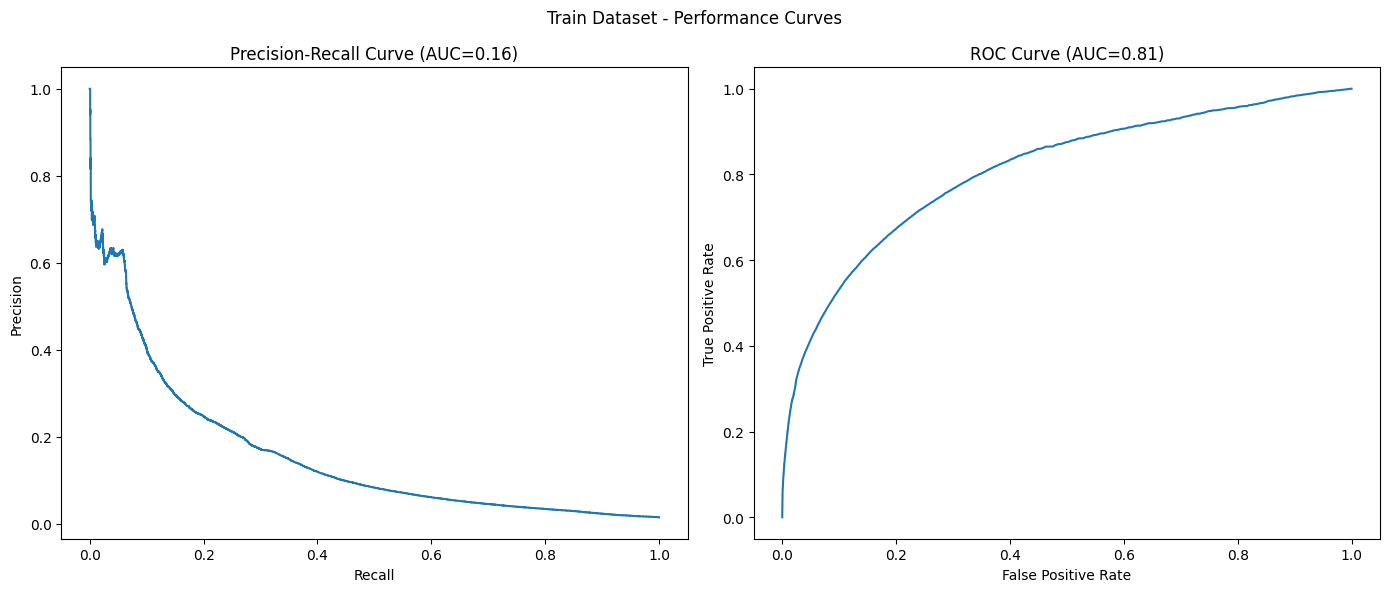

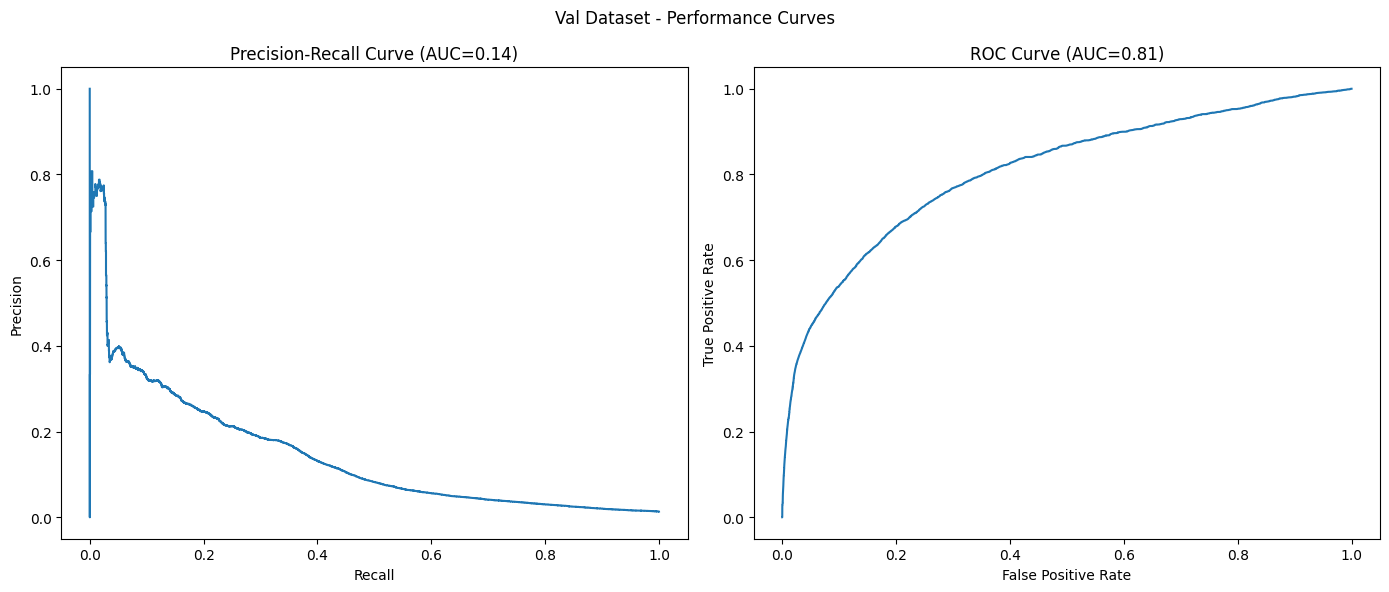

In [16]:
# Define the columns to be used
reduced_cols = ['ordered_before', 'global_popularity', 'abandoned_before', 'normalised_price']

# Define hyperparameter for the level of regularization
c = 1e-3

# Create a pipeline with StandardScaler and LogisticRegression
lr = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty='l2', C=1e-4)
)

# Fit the model on the training data
lr.fit(X_train[reduced_cols], Y_train)

# Predict scores for the positive class on the training set
train_proba2 = lr.predict_proba(X_train[reduced_cols])[:, 1]
plot_curves(Y_train, train_proba2, curve_type="both", dataset_type="train")

# Predict score for the positive class on the validation set
val_proba2 = lr.predict_proba(X_val[reduced_cols])[:, 1]
plot_curves(Y_val, val_proba2, curve_type="both", dataset_type="val")

plt.show()


As we can observe, this model provided an AUC of the Precision-Recall curve of 0.16 and 0.14 for the training and validation sets respectively. On the other hand, the AUC of the ROC curve had a value of 0.81 for both subsets.

### 4. Non-linear Models
We will now try to improve our model by increasing its complexity.

#### 4.1 Random Forest
In a Random Forest, each tree receives a subset of the data, and each split only looks at a random subset of the features. Additionaly, the trees are constructed until the end and the decision is made by a voting process. Furthermore, it is worth mentioning that is hass three hyperparameters: the number of trees, the variables at each split, and the sample size at each tree. Nevertheless, we will only define the number of trees, and set the other hyperparameters with their default value.

It is also worth mentioning that now we do not need to scale the data, as there is no need to add regularisation.

In [17]:
def evaluate_configuration(model, X_train, Y_train, X_val, Y_val):
    """Evaluates a given model by returning its ROC AUC score, Cross Entropy loss, and Average Precision 
    score for both train and validation datasets."""
    
    # Predictions and probabilities
    train_predictions = model.predict_proba(X_train)[:,1]
    val_predictions = model.predict_proba(X_val)[:,1]
    
    # ROC AUC scores
    train_auc = roc_auc_score(Y_train, train_predictions)
    val_auc = roc_auc_score(Y_val, val_predictions)
    
    # Cross Entropy loss
    train_ce = log_loss(Y_train, train_predictions)
    val_ce = log_loss(Y_val, val_predictions)
    
    # Average Precision score
    train_ap = average_precision_score(Y_train, train_predictions)
    val_ap = average_precision_score(Y_val, val_predictions)
    
    return train_auc, val_auc, train_ce, val_ce, train_ap, val_ap

In [18]:
n_trees_list = [5, 25, 50, 100]

for n_trees in n_trees_list:
    rf = RandomForestClassifier(n_estimators = n_trees)
    rf.fit(X_train[numerical_cols], Y_train)
    
    train_auc, val_auc, train_ce, val_ce, train_ap, val_ap = evaluate_configuration(rf, X_train[numerical_cols], Y_train, 
                                                                                    X_val[numerical_cols], Y_val)
    print(f"For {n_trees} trees:")
    print(f"Train AUC: {train_auc:.4f}, Validation AUC: {val_auc:.4f}")
    print(f"Train Cross Entropy: {train_ce:.4f}, Validation Cross Entropy: {val_ce:.4f}")
    print(f"Train Average Precision: {train_ap:.4f}, Validation Average Precision: {val_ap:.4f}")
    print()
    

For 5 trees:
Train AUC: 0.9885, Validation AUC: 0.6201
Train Cross Entropy: 0.0273, Validation Cross Entropy: 0.3661
Train Average Precision: 0.7240, Validation Average Precision: 0.0510

For 25 trees:
Train AUC: 0.9939, Validation AUC: 0.6893
Train Cross Entropy: 0.0232, Validation Cross Entropy: 0.2671
Train Average Precision: 0.8149, Validation Average Precision: 0.0794

For 50 trees:
Train AUC: 0.9943, Validation AUC: 0.7102
Train Cross Entropy: 0.0231, Validation Cross Entropy: 0.2324
Train Average Precision: 0.8239, Validation Average Precision: 0.0865

For 100 trees:
Train AUC: 0.9945, Validation AUC: 0.7313
Train Cross Entropy: 0.0230, Validation Cross Entropy: 0.1963
Train Average Precision: 0.8275, Validation Average Precision: 0.0913



We can observe that, as the number of trees increases, the model's performance on the validation set consistently improves. With only 5 trees, the model overfits the training data, evidenced by high training AUC and low validation AUC, alongside with high validation Cross Entropy and poor validation Average Precision. Increasing the number of trees to 25, 50, and 100 results in progressively better generalization, as indicated by rising validation AUC and Average Precision scores, and decreasing validation Cross Entropy loss. This trend suggests that using a larger number of trees enhances the model's ability to generalize from the training data to unseen validation data, with the best overall performance observed at 100 trees.

It is worth mentioning that the high variance is probably due to the fact that there is correlation between features, and therefore correlation between trees. Additionally, it is worth remembering that, in the Random Forest training, it is normal to have an AUC of 100%, as trees are constructed until the end and therefore each point arrives at a node. Nevertheless, in our case, it is not exactly 100%, as there is some node that has an instance of another class. In other words, there are samples with same input but different output, which indicates that there is either noise or we need more features (additional features may make previous equal instances different).

Now, we plot a feature importance plot to drop the lowest importance variables and see how the model performs.

In [19]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train[numerical_cols], Y_train)

RandomForestClassifier()

In [20]:
def do_feature_importance(model, X_train):
    # Get feature importances
    importances = model.feature_importances_
    feature_names = X_train.columns

    # Create a DataFrame for better visualization
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })

    # Sort the DataFrame by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Plot feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.title('Feature Importances')
    plt.gca().invert_yaxis() 
    plt.show()


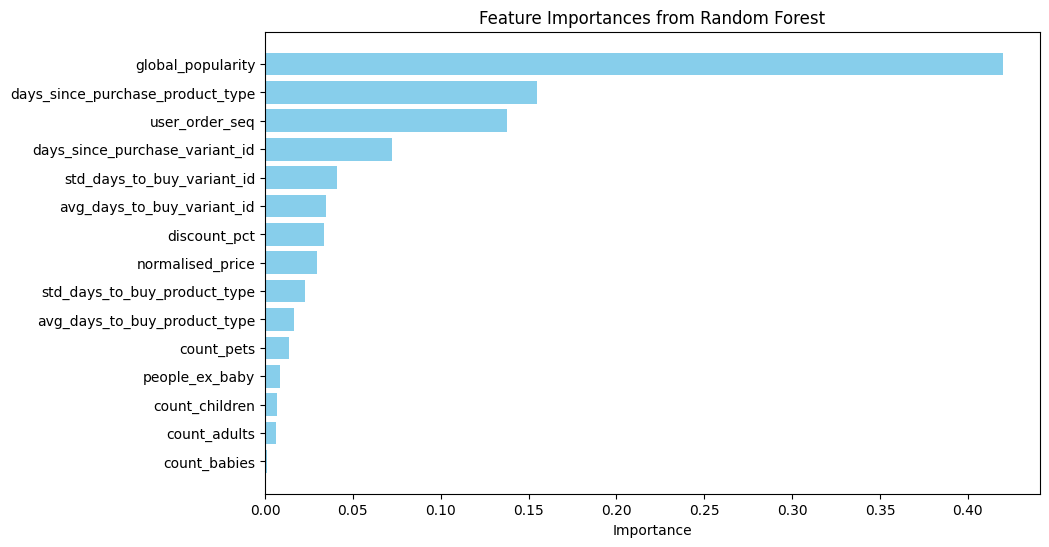

In [21]:
do_feature_importance(rf, X_train[numerical_cols])

We now select only the features with highest importance:

In [22]:
selected_cols = ['global_popularity', 'days_since_purchase_product_type', 'user_order_seq', 'days_since_purchase_variant_id', 
                 'std_days_to_buy_variant_id', 'avg_days_to_buy_variant_id', 'discount_pct', 'normalised_price']

for n_trees in n_trees_list:
    rf = RandomForestClassifier(n_estimators = n_trees)
    rf.fit(X_train[selected_cols], Y_train)
    
    train_auc, val_auc, train_ce, val_ce, train_ap, val_ap = evaluate_configuration(rf, X_train[selected_cols], Y_train, 
                                                                                    X_val[selected_cols], Y_val)
    print(f"For {n_trees} trees:")
    print(f"Train AUC: {train_auc:.4f}, Validation AUC: {val_auc:.4f}")
    print(f"Train Cross Entropy: {train_ce:.4f}, Validation Cross Entropy: {val_ce:.4f}")
    print(f"Train Average Precision: {train_ap:.4f}, Validation Average Precision: {val_ap:.4f}")
    print()

For 5 trees:
Train AUC: 0.9879, Validation AUC: 0.6227
Train Cross Entropy: 0.0279, Validation Cross Entropy: 0.3607
Train Average Precision: 0.7056, Validation Average Precision: 0.0538

For 25 trees:
Train AUC: 0.9933, Validation AUC: 0.6964
Train Cross Entropy: 0.0240, Validation Cross Entropy: 0.2553
Train Average Precision: 0.7969, Validation Average Precision: 0.0837

For 50 trees:
Train AUC: 0.9937, Validation AUC: 0.7172
Train Cross Entropy: 0.0239, Validation Cross Entropy: 0.2202
Train Average Precision: 0.8053, Validation Average Precision: 0.0891

For 100 trees:
Train AUC: 0.9939, Validation AUC: 0.7387
Train Cross Entropy: 0.0238, Validation Cross Entropy: 0.1829
Train Average Precision: 0.8090, Validation Average Precision: 0.0919



Once again, we can observe that as the number of trees increases, the model's performance on the validation set consistently improves. Increasing the number of trees results in progressively better generalization, as indicated by rising validation AUC and Average Precision scores, and decreasing validation Cross Entropy loss. 

We also have still high variance due to the fact that there is correlation between features, and therefore correlation between trees. Additionally, we don't have an AUC of exactly 100%, as there are samples with same input but different output, which indicates that there is either noise or we need more features (additional features may make previous equal instances different).

We can observe that reducing columns has increased the performance (validation with increased AUC, decreased Cross Entropy and increased validation precision), has this has probably made the correlation between trees decrease, and so they are more independent. Finally, the results are worse than those with Logistic Regression.

#### 4.2 Gradient Boosting tress
Gradient Boostring trees are constructed by taking the mean of the data and iteratively computing the gradient of the loss (predicting it using a new tree). Furthermore, their hyperparameters are: number of trees, learning rate, tree depth and regularisation terms of the loss.

In [23]:
n_trees_list = [5, 25, 50, 100]
lrs = [0.05, 0.1]
tree_depths = [1, 3, 5]

for lr in lrs:
    for depth in tree_depths:
        for n_trees in n_trees_list:
            gb = GradientBoostingClassifier(n_estimators = n_trees, learning_rate = lr, max_depth = depth)
            gb.fit(X_train[numerical_cols], Y_train)
            
            train_auc, val_auc, train_ce, val_ce, train_ap, val_ap = evaluate_configuration(gb, X_train[numerical_cols], Y_train, 
                                                                                            X_val[numerical_cols], Y_val)
            print(f"For a learning rate of {lr}, a depth of {depth}, and {n_trees} trees,:")
            print(f"Train AUC: {train_auc:.4f}, Validation AUC: {val_auc:.4f}")
            print(f"Train Cross Entropy: {train_ce:.4f}, Validation Cross Entropy: {val_ce:.4f}")
            print(f"Train Average Precision: {train_ap:.4f}, Validation Average Precision: {val_ap:.4f}")
            print()
    

For a learning rate of 0.05, a depth of 1, and 5 trees,:
Train AUC: 0.6937, Validation AUC: 0.6921
Train Cross Entropy: 0.0756, Validation Cross Entropy: 0.0686
Train Average Precision: 0.0542, Validation Average Precision: 0.0737

For a learning rate of 0.05, a depth of 1, and 25 trees,:
Train AUC: 0.7832, Validation AUC: 0.7907
Train Cross Entropy: 0.0712, Validation Cross Entropy: 0.0636
Train Average Precision: 0.0861, Validation Average Precision: 0.1226

For a learning rate of 0.05, a depth of 1, and 50 trees,:
Train AUC: 0.8024, Validation AUC: 0.8157
Train Cross Entropy: 0.0691, Validation Cross Entropy: 0.0613
Train Average Precision: 0.0976, Validation Average Precision: 0.1360

For a learning rate of 0.05, a depth of 1, and 100 trees,:
Train AUC: 0.8117, Validation AUC: 0.8265
Train Cross Entropy: 0.0675, Validation Cross Entropy: 0.0595
Train Average Precision: 0.1046, Validation Average Precision: 0.1436

For a learning rate of 0.05, a depth of 3, and 5 trees,:
Train AUC: 

We select the set of hyperparameters that make the model perform the best and do feature importance. The combination that provides the highest validation AUC, the lowest validation Cross Entropy, and the highes validation Average Precision, indicating it has the best overall performance, is: learning rate: 0.05, depth: 5, and 100 trees.


In [24]:
lr_best = 0.05
tree_depth_best = 5
n_trees_best = 100

gb = GradientBoostingClassifier(n_estimators = n_trees_best, learning_rate = lr_best, max_depth = tree_depth_best)
gb.fit(X_train[numerical_cols], Y_train)

GradientBoostingClassifier(learning_rate=0.05, max_depth=5)

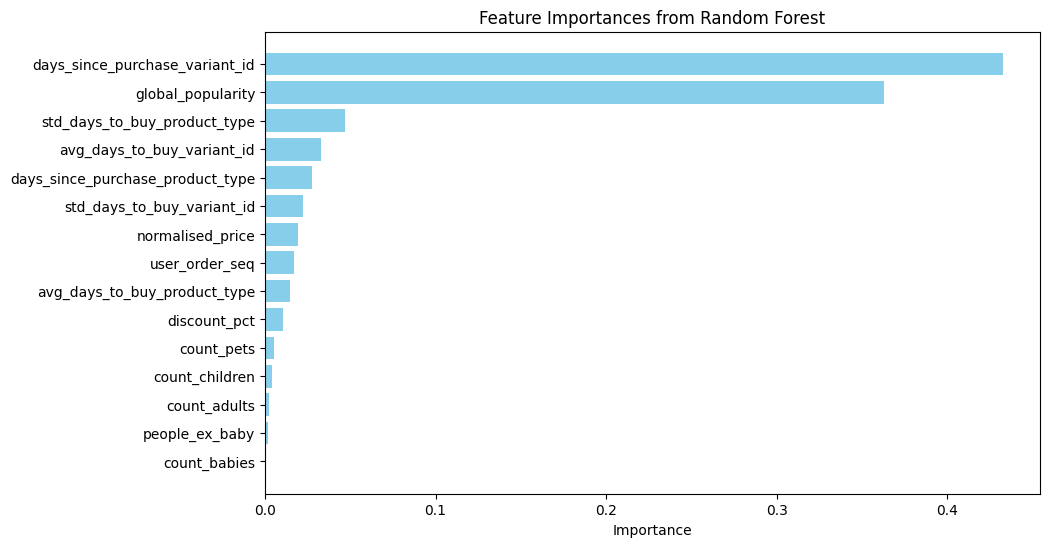

In [25]:
do_feature_importance(gb, X_train[numerical_cols])

In [27]:
selected_cols = ['days_since_purchase_product_type', 'global_popularity', 'std_days_to_buy_product_type', 
                 'avg_days_to_buy_variant_id', 'days_since_purchase_product_type', 'std_days_to_buy_variant_id', 
                 'normalised_price', 'user_order_seq', 'avg_days_to_buy_product_type']

for lr in lrs:
    for depth in tree_depths:
        for n_trees in n_trees_list:
            gb = GradientBoostingClassifier(n_estimators = n_trees, learning_rate = lr, max_depth = depth)
            gb.fit(X_train[numerical_cols], Y_train)
            
            train_auc, val_auc, train_ce, val_ce, train_ap, val_ap = evaluate_configuration(gb, X_train[numerical_cols], Y_train, 
                                                                                            X_val[numerical_cols], Y_val)
            print(f"For a learning rate of {lr}, a depth of {depth}, and {n_trees} trees,:")
            print(f"Train AUC: {train_auc:.4f}, Validation AUC: {val_auc:.4f}")
            print(f"Train Cross Entropy: {train_ce:.4f}, Validation Cross Entropy: {val_ce:.4f}")
            print(f"Train Average Precision: {train_ap:.4f}, Validation Average Precision: {val_ap:.4f}")
            print()
    

For a learning rate of 0.05, a depth of 1, and 5 trees,:
Train AUC: 0.6937, Validation AUC: 0.6921
Train Cross Entropy: 0.0756, Validation Cross Entropy: 0.0686
Train Average Precision: 0.0542, Validation Average Precision: 0.0737

For a learning rate of 0.05, a depth of 1, and 25 trees,:
Train AUC: 0.7832, Validation AUC: 0.7907
Train Cross Entropy: 0.0712, Validation Cross Entropy: 0.0636
Train Average Precision: 0.0861, Validation Average Precision: 0.1226

For a learning rate of 0.05, a depth of 1, and 50 trees,:
Train AUC: 0.8024, Validation AUC: 0.8157
Train Cross Entropy: 0.0691, Validation Cross Entropy: 0.0613
Train Average Precision: 0.0976, Validation Average Precision: 0.1360

For a learning rate of 0.05, a depth of 1, and 100 trees,:
Train AUC: 0.8117, Validation AUC: 0.8265
Train Cross Entropy: 0.0675, Validation Cross Entropy: 0.0595
Train Average Precision: 0.1046, Validation Average Precision: 0.1436

For a learning rate of 0.05, a depth of 3, and 5 trees,:
Train AUC: 

The set of hyperparameters that achieves one of the highest AUCs, lowest Cross Entropies, and the highest Average Precision is learning rate of 0.05, depth 5 and 50 trees. Therefore, it represents the best balance among the three metrics.

### 5. Comparing selected models

In [51]:
# Logistic Regression
reduced_cols = ['ordered_before', 'global_popularity', 'abandoned_before', 'normalised_price']
lr = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty='l2', C=1e-4)
)

lr.fit(X_train[reduced_cols], Y_train)
lr_predictions = lr.predict_proba(X_test[reduced_cols])[:, 1]


# Random Forest
selected_cols = ['global_popularity', 'days_since_purchase_product_type', 'user_order_seq', 'days_since_purchase_variant_id', 
                 'std_days_to_buy_variant_id', 'avg_days_to_buy_variant_id', 'discount_pct', 'normalised_price', 
                 'std_days_to_buy_product_type', 'avg_days_to_buy_product_type', 'count_pets']

rf = RandomForestClassifier(n_estimators = 100)
rf.fit(X_train[selected_cols], Y_train)
rf_predictions = rf.predict_proba(X_test[selected_cols])[:, 1]


# Gradient Boosting
selected_cols = ['days_since_purchase_product_type', 'global_popularity', 'std_days_to_buy_product_type', 
                 'avg_days_to_buy_variant_id', 'days_since_purchase_product_type', 'std_days_to_buy_variant_id', 
                 'normalised_price', 'user_order_seq', 'avg_days_to_buy_product_type']

gb = GradientBoostingClassifier(n_estimators = 50, learning_rate = 0.05, max_depth = 5)
gb.fit(X_train[selected_cols], Y_train)
gb_predictions = gb.predict_proba(X_test[selected_cols])[:, 1]

In [52]:
def compute_metrics(y_true, predictions):
    metrics = {}
    for model_name, preds in predictions.items():
        precision, recall, _ = precision_recall_curve(y_true, preds)
        fpr, tpr, _ = roc_curve(y_true, preds)
        auc_score = auc(fpr, tpr)
        ap_score = average_precision_score(y_true, preds)
        
        metrics[model_name] = {
            'precision': precision,
            'recall': recall,
            'fpr': fpr,
            'tpr': tpr,
            'auc': auc_score,
            'ap': ap_score
        }
    
    return metrics


In [53]:
def plot_metrics(metrics):
    # Plot Precision-Recall curves
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    for model_name, metric in metrics.items():
        plt.plot(metric['recall'], metric['precision'], label=f'{model_name} (AP={metric["ap"]:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()

    # Plot ROC curves
    plt.subplot(1, 2, 2)
    for model_name, metric in metrics.items():
        plt.plot(metric['fpr'], metric['tpr'], label=f'{model_name} (AUC={metric["auc"]:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()


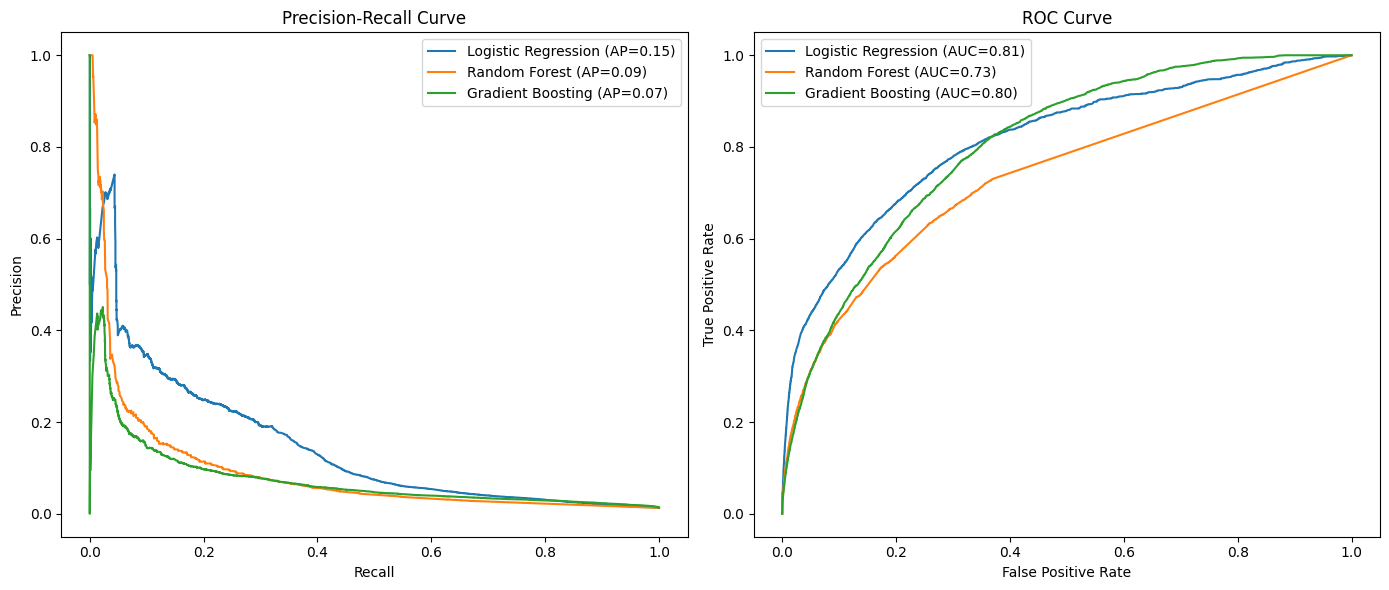

: 

In [54]:
# Example usage with your predictions
predictions = {
    'Logistic Regression': lr_predictions,
    'Random Forest': rf_predictions,
    'Gradient Boosting': gb_predictions
}

metrics = compute_metrics(Y_test, predictions)
plot_metrics(metrics)

We can osberve that in the Precision-Recall Curve, the Logistic Regression has the highest average precision (AP),compared to Random Forest and Gradient Boosting. Furthermore, Random Forest has a moderate AP, while Gradient Boosting has the lowest AP, indicating weaker performance in distinguishing the positive class.

On the other hand, in the ROC Curve, Logistic Regression and Gradient Boosting show similar performance with AUCs of 0.81 and 0.80, respectively. Random Forest performs worse with an AUC of 0.73, indicating a higher rate of false positives and/or false negatives compared to the other two models.

In conclusion, Logistic Regression is the best performer in terms of both Precision-Recall and ROC metrics; Gradient Boosting has comparable ROC performance to Logistic Regression but performs worse in the Precision-Recall metric; and, finally, Random Forest has the lowest performance in both Precision-Recall and ROC metrics.